<div style="font-size:12pt; line-height:1.4;">
    
### О чем эта практическая работа:

Работа посвящена обработке результатов молекулярной динамики.  
Здесь вы найдёте методы интерактивной обработки с помощью Python.

Также в работе рассматриваются детали моделирования машинно-обучаемыми потенциалами (Machine Learning Interatomic Potentials, **MLIPs**): от подходов к обучению до предсказания свойств и оценки их воспроизводимости.

<div style="font-size:12pt; line-height:1.4;">
    
### Краткое содержание работы
Эта практическая работа содержит результаты, полученные для статьи  
[«Active learning and explicit electrostatics enable accurate modeling of electrolytes»](https://arxiv.org/abs/2510.03479).

#### Что будем делать
Будем обрабатывать результаты молекулярно-динамического моделирования, проведённого с помощью **MTP** (Moment Tensor Potential [\[Novikov 2020\]](https://iopscience.iop.org/article/10.1088/2632-2153/abc9fe/meta)) для двух систем:  
1. бинарной смеси растворителей этиленкарбоната (ethylene carbonate, **EC**) и этилметилкарбоната (ethyl methyl carbonate, **EMC**);  
2. 1 М раствора LiPF₆ в чистом EC.

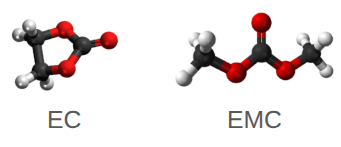

#### Мотивация
Литий-ионные аккумуляторы используются повсеместно; их характеристики зависят от электролита, который служит проводящей средой для носителей заряда. Чтобы оптимизировать характеристики аккумулятора, нужно подобрать состав электролита: концентрацию соли и состав растворителя (обычно используется смесь нескольких растворителей). EC и EMC — распространённые растворители, LiPF₆ — часто используемая соль.

Можно подбирать соотношение EC/EMC и концентрацию LiPF₆ экспериментально, но это требует значительных временных и материальных затрат. Поэтому выгодно использовать атомистическое моделирование.

Классический выбор — *ab initio* молекулярная динамика (AIMD) или (полу)эмпирические силовые поля. 
AIMD (обычно с DFT) даёт высокую точность, но из-за скорости вычислений применима только к системам в десятки атомов и на временах до десятков пикосекунд. Этого масштаба недостаточно для точного расчёта коэффициентов диффузии и ионной проводимости — величин, представляющих ключевой интерес. 
Силовые поля позволяют достичь нужного масштаба моделирования, но их точности часто не хватает для физически релевантного описания структуры электролита. [\[Ong 2015\]](https://pubs.acs.org/doi/abs/10.1021/jp508184f)

Машинно-обучаемые потенциалы сочетают точность AIMD и скорость силовых полей, что делает их оптимальными для моделирования электролитов (и не только).

# Загрузка модулей

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Смеси EC/EMC

## Анализ обучающей выборки потенциала

<div style="font-size:12pt; line-height:1.4;">

Для моделирования смесей EC/EMC, можно построить MTP, который был бы способен моделировать смесь EC/EMC с любым соотношением компонентов.

Для этого в обучающей выборке должны присутствовать конфигурации со всеми вариантами концентраций: от чистого EC до чистого EMC. 
Чтобы собрать такую обучающую выборку, мы провели активное обучение (Active Learning, **AL** [\[Novikov 2020\]](https://iopscience.iop.org/article/10.1088/2632-2153/abc9fe/meta)), где новые конфигурации отбирались из нескольких параллельных молекулярных динамик, запущенных с чистых EC и EMC, а также с ячеек с составом xEC:(10-x)EMC, где x=1,..,9.

В нашем случае уже были доступны обучающие выборки для чистых EC и EMC, и мы их использовали для предварительного обучения потенциала, чтобы сократить время, которое потребуется на активное обучение. 
Для этого, поскольку молекулы EC и EMC структурно похожи, вместо того чтобы предварительно обучать потенциал на скомбинированных выборках чистых компонентов, мы отобрали для обучения наиболее разнообразные конфигурации из скомбинированных выборок с помощью команды кода ```MLIP-2``` `select-add`. Таким образом, мы избежали завышения числа реально необходимых конфигураций в обучающей выборке (что увеличит скорость обучения потенциала). После предварительного обучения было запущено активное обучение в ходе нескольких молекулярных динамик, как описано ранее.

В последующих ячейках вы найдёте функции для чтения конфигураций из обучающей выборки и для их визуализации.

### Вспомогательные функции

<div style="font-size:12pt; line-height:1.4;">

В ходе работы мы будем пользоваться модулем [ASE](https://ase-lib.org/) — распространённым инструментом для проведения симуляций и обработки результатов в Python. В ASE определён объект `Atoms`, способный хранить сведения о структуре — от координат до зарядов, — для которого уже написано множество удобных функций и методов, их можно найти в документации ASE.

Мы также будем использовать модуль [Chemiscope](https://chemiscope.org/) (чтобы открыть ссылку, понадобится VPN) — удобный инструмент для визуализации структур, позволяющий сопоставлять структуру с её свойствами, такими как энергия, плотность и силы на атомах.

In [2]:
from ase import Atoms

In [3]:
def read_cfg2atoms(filename, specorder):
    """
    Функция для чтения конфигураций из .cfg формата MLIP-2 в объект ase.Atoms 
    """

    atoms_list = []
    with open(filename, 'r') as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        if line == 'BEGIN_CFG':
            i += 1
            # Чтение числа атомов в конфигурации
            if 'Size' in lines[i]:
                n_atoms = int(lines[i+1].strip())
                i += 2

            # Чтение параметров ячейки
            if 'Supercell' in lines[i]:
                i += 1
                cell = []
                for _ in range(3):
                    cell.append(list(map(float, lines[i].split())))
                    i += 1
                cell = np.array(cell)

            # Чтение типов атомов, их координат и сил
            if 'AtomData:' in lines[i]:
                i += 1
                positions = []
                forces = []
                atomic_types = []
                for _ in range(n_atoms):
                    parts = lines[i].split()
                    atom_type = int(parts[1])
                    x, y, z = map(float, parts[2:5])
                    fx, fy, fz = map(float, parts[5:8])
                    positions.append([x, y, z])
                    forces.append([fx, fy, fz])
                    atomic_types.append(specorder[atom_type])
                    i += 1

            # Чтение энергии
            if 'Energy' in lines[i]:
                i += 1
                energy = float(lines[i].strip())
                i += 1

            # Переход к следующей конфигурации
            if 'END_CFG' in lines[i]:
                i += 1

            # Создание объекта ase.Atoms
            atoms = Atoms(
                numbers=atomic_types,
                positions=positions,
                cell=cell,
                pbc=True
            )
            atoms.arrays['forces'] = np.array(forces)
            atoms.info['energy'] = energy
            atoms_list.append(atoms)
        else:
            i += 1

    return atoms_list

In [4]:
import chemiscope
def visualize_chemiscope(atoms, name1, var1, name2, var2):
    """
    Функция для визуализации структур и сопоставления с их свойствами.
    """
    widget = chemiscope.show(atoms, {name1: var1,
                                     name2: var2
                                    },
                                 settings={
                                   "structure": [
                                        {
                                            "unitCell": True,
                                            "keepOrientation": True,
                                        }
                                    ],
                                 }
                            )
    return widget

### Анализ обучающей выборки

In [5]:
# Определяем соответствие между типами атомов используемыми в .cfg файле (в MLIP-2 тип атома не имеет физического смысла, это его идентификатор) 
# и фактическими типами атомов
specorder = {0:8, 1:6, 2:1}

# считываем обучающую выборку потенциала
train_true = read_cfg2atoms('./ECEMC/training_set/train.cfg', specorder)

# считываем обучающую выборку потенциала с предсказанными энергиями и силами
train_predicted = read_cfg2atoms('./ECEMC/training_set/train.cfg', specorder)

<div style="font-size:12pt; line-height:1.4;">  

Поскольку обучающая выборка состоит из смесей EC/EMC, то информативно будет визуализировать зависимость плотности (это позволит визуально разделить конфигурации соответствующие разным соотношениям EC/EMC) от энергии на атом (поскольку EC и EMC имеют разное число атомов):

In [8]:
visualize_chemiscope(train_true, 
                     'Density', [np.sum(x.get_masses())/x.get_volume() for x in train_true],
                     'E/atom', [x.info['energy']/len(x) for x in train_true])

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'unitCell': True, 'keepOrientation': True}]}, s…

<div style="font-size:12pt; line-height:1.4;"> 
    
Также информативно смотреть на зависимость предсказанных энергий/сил от истинных, чтобы определить если ли в обучающей выборке нефичизные конфигурации, которые потенциалу сложно правильно предсказать.

In [9]:
visualize_chemiscope(train_true, 
                     'True energy', [x.info['energy'] for x in train_true],
                     'Predicted energy', [x.info['energy'] for x in train_predicted])

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'unitCell': True, 'keepOrientation': True}]}, s…

<div style="font-size:12pt; line-height:1.4;">  

**Дополнительное задание:**
молекулы выглядят "порванными" из-за периодических граничных условий. Их можно достроить до целых с помощью функции ```wrap_molecs``` модуля ```anaAtoms``` из репозитория [aseMolec](https://github.com/imagdau/aseMolec).

## Плотности

<div style="font-size:12pt; line-height:1.4;">  

В последующих ячейках мы получим плотность для чистых EC и EMC и для их смесей: 7EC:3EMC и 3EC:7EMC.  
Также мы оценим, насколько различается точность предсказания плотности с помощью MTP 16-го уровня (далее **MTP16**, 383 параметра) и MTP 20-го уровня (далее **MTP20**, 651 параметр). Использование модели с меньшим числом параметров даёт преимущество в скорости вычислений, но может приводить к потере точности. Поэтому необходимо убедиться, можно ли пользоваться MTP16 или нет.

Также нужно учесть, что когда потенциал обучается, начальные значения его параметров инициализируются случайно, и конечные значения параметров зависят от этого. Поэтому, чтобы оценить точность и воспроизводимость предсказания величины потенциалом, нужно учесть её чувствительность к случайной инициализации параметров. Для этого используют ансамбль потенциалов: рассчитывают величину не одним MTP, а тремя или больше.

Поэтому для расчёта плотности мы провели 300 пс молекулярной динамики в NPT-ансамбле с 3 MTP16 и 3 MTP20.

<div style="font-size:12pt; line-height:1.4;">  
    
Входной скрипт для расчетов в LAMMPS выглядел так:  
```
-----------------------------------------------------------------------------
#----------------------------- Общие настройки -------------------------------
#-----------------------------------------------------------------------------
clear
units metal
dimension 3
boundary p p p
atom_style atomic

#-----------------------------------------------------------------------------
#------------------------ Импорт исходной структуры --------------------------
#-----------------------------------------------------------------------------
read_data structure.data
replicate 3 3 3

#-----------------------------------------------------------------------------
#---------------------- Импорт обученного потенциала -------------------------
#-----------------------------------------------------------------------------
pair_style mlip mlip.ini
pair_coeff * *

#-----------------------------------------------------------------------------
#----------------------------- Другие настройки ------------------------------
#-----------------------------------------------------------------------------
variable T equal 300 # температура
variable P equal 0   # давление
timestep 0.001       # шаг по времени в пс
neighbor 0.5 bin
neigh_modify delay 1 check yes

#-----------------------------------------------------------------------------
#---------------------------- Настройки вывода -------------------------------
#-----------------------------------------------------------------------------
thermo 100
thermo_style custom step etotal pe ke temp enthalpy vol press density

#-----------------------------------------------------------------------------
#--------------------------- Настройки симуляции -----------------------------
#-----------------------------------------------------------------------------
velocity all create $T 123456 dist gaussian # задание начальных скоростей

fix 1 all npt temp $T $T 0.1 iso $P $P 1    # задание параметров NPT симуляции
run 300000                                  # число шагов 
unfix 1

print "All done!"

```

In [6]:
# Рассматриваемые составы смесей
mixtures = ['EC', '7EC3EMC', '3EC7EMC', 'EMC']

In [7]:
# Экспериментальные плотности в г/см^3
rho_experimental = {'EC': 1.34, '7EC3EMC':1.2, '3EC7EMC': 1.1, 'EMC': 1.0, }

In [8]:
# Функция чтобы считывать лог-файл LAMMPS
def parse_lammps_log (path):
    looped = False
    with open (path,'r') as f:
        lines = f.readlines()
        for i,line in enumerate(lines):
            if 'Step' in line:
                i_start=i
            elif 'Loop' in line:
                i_stop=i
                break
        data = pd.read_table(path, skiprows=i_start, nrows=i_stop-i_start-1, sep="\s+")
    return data

In [9]:
# Чтение лог-файлов
ecemc_logs = {'lev16': {}, 'lev20': {}}

path1 = './ECEMC/lev16/'
path2 = './ECEMC/lev20/'
for mixture in mixtures: # цикл по составам 
    ecemc_logs['lev16'][mixture] = []
    ecemc_logs['lev20'][mixture] = []
    for i in range(3): # цикл по индивидуальным потенциалам в ансамбле
        # чтение результатов для MTP 16-го уровня 
        # обрезаются первые 500 записанных значений поскольку в это время происходила эквилибранция
        ecemc_logs['lev16'][mixture].append(parse_lammps_log(f'{path1}/{i}/{mixture}/log.lammps')[500:])    
        # чтение результатов для MTP 20-го уровня 
        ecemc_logs['lev20'][mixture].append(parse_lammps_log(f'{path2}/{i}/{mixture}/log.lammps')[500:])    

In [10]:
# Так выглядит прочитаный лог LAMMPS, полученный для смеси 3EC:7EMC с помощью 0-го потенциала в ансамбле потенциалов MTP 16-го уровня
ecemc_logs['lev16']['3EC7EMC'][0]

,Step,TotEng,PotEng,KinEng,Temp,Enthalpy,Volume,Press,Density
500,50000,-21158.001,-21302.804,144.80241,307.42046,-21154.911,36524.485,135.54842,1.218831
501,50100,-21159.795,-21301.495,141.70034,300.83466,-21148.051,36728.608,512.27002,1.212057
502,50200,-21165.578,-21303.997,138.41919,293.86867,-21159.430,36866.880,267.16181,1.207511
503,50300,-21164.145,-21302.842,138.69706,294.45860,-21195.067,36859.913,-1344.08630,1.207739
504,50400,-21161.030,-21305.340,144.30979,306.37462,-21133.303,36768.551,1208.18640,1.210740
...,...,...,...,...,...,...,...,...,...
2996,299600,-21166.206,-21307.079,140.87262,299.07739,-21134.068,36309.404,1418.11860,1.226051
2997,299700,-21164.574,-21304.653,140.07917,297.39286,-21183.574,36425.336,-835.70478,1.222148
2998,299800,-21164.259,-21305.066,140.80735,298.93882,-21231.277,36434.753,-2947.07200,1.221833
2999,299900,-21163.619,-21303.376,139.75656,296.70795,-21167.293,36356.957,-161.89721,1.224447


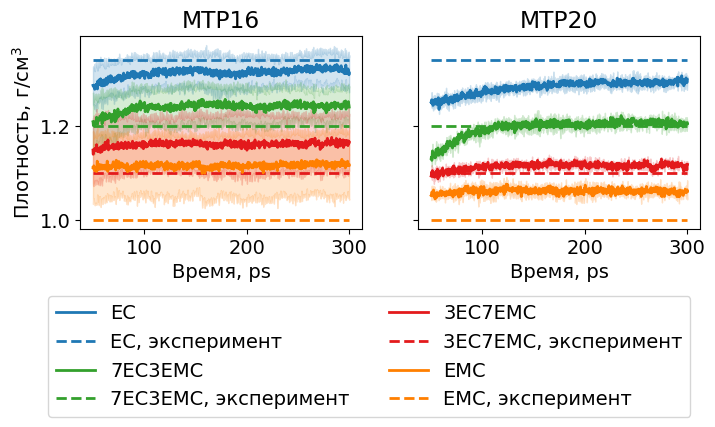

In [11]:
# Строим зависимость плотности от времени
fig,ax = plt.subplots(1,2, figsize=(8,2.5), sharey = True)
cmap = plt.get_cmap('Paired')
colors = cmap(np.arange(1,9,2))

# Получаем время
time = ecemc_logs['lev16']['EC'][0]['Step']*0.001 # перевод из шагов в ps

for k,pot_tag in enumerate(['lev16', 'lev20']): # цикл по уровням MTP
    for i,key in enumerate(mixtures): # цикл по составам смесей
        densities = np.array([ecemc_logs[pot_tag][key][j]['Density'] for j in range(3)])
        # строим среднюю плотность по ансамблю потенциалов
        ax[k].plot(time, np.mean(densities,axis=0), linewidth = 2, color = colors[i], label = key)
        # строим область неопределенности в 1 стандартное отклонение (из-за случайной инициализации параметров потенциалов)
        ax[k].fill_between(time, 
                           np.mean(densities,axis=0)+ np.std(densities,axis=0),
                           np.mean(densities,axis=0)-np.std(densities,axis=0), 
                           color = colors[i], alpha = 0.2)
        # строим экспериментальное значение плотности
        ax[k].hlines(rho_experimental[key], np.min(time), np.max(time), 
                   linestyle='--', color = colors[i], linewidth = 2, label =f'{key}, эксперимент')
    ax[k].set_xlabel('Время, ps')
    
ax[0].set_ylabel('Плотность, г/см$^3$')
ax[0].set_title(r'MTP16')
ax[1].set_title(r'MTP20')
ax[1].legend(bbox_to_anchor=(1, -0.3), ncols = 2)   

plt.show()

<div style="font-size:12pt; line-height:1.4;">   
    
По результатам мы видим, что точности MTP16 недостаточно, поскольку области неопределённости для предсказанных плотностей чистого EMC и 3EC:7EMC значительно перекрываются — то есть MTP16 не способен хорошо различать эти две системы. Также MTP16 предсказывает плотность чистого EMC с ошибкой более 10 %.

В то же время для MTP20:
1. средние значения плотностей ближе к эксперименту (максимальная ошибка 6%)  
2. неопределённость из-за случайной инициализации параметров потенциала значительно ниже, чем у MTP16.

<div style="font-size:12pt; line-height:1.4;">  

**Дополнительное задание:**  
Исходя из графиков плотности от времени можно подумать, что точнее всего потенциал предсказывает смесь 7EC:3EMC. Однако, когда предсказанная величина сравнивается с экспериментом, нужно учитывать два источника содержащихся в ней ошибок: ошибку потенциала по сравнению с уровнем теории, на котором была посчитана обучающая выборка (PBE-D3), и ошибку между PBE-D3 и экспериментом. Между этими двумя видами ошибок возможно взаимное сокращение.

Чтобы в действительности понять, какой состав смеси потенциал описывает наиболее точно, нужно сравнивать его предсказания с предсказаниями PBE-D3. Это можно сделать, проведя AIMD, но это требует значительных вычислительных ресурсов. Намного быстрее — сравнить предсказанные силы и энергии.

Однако плотность определяется межмолекулярными взаимодействиями, тогда как силы и энергии, полученные стандартными методами (не SAPT, например), — сумма внутри- и межмолекулярных. Внутри- и межмолекулярные компоненты можно разделить. Для этого можно использовать модуль [aseMolec](https://github.com/imagdau/aseMolec), как было сделано в статьях [Magdau 2023](https://www.nature.com/articles/s41524-023-01100-w), [Chalykh 2025](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dsVfICgAAAAJ&citation_for_view=dsVfICgAAAAJ:M05iB0D1s5AC).

В результате анализа точности предсказания межмолекулярных взаимодействий вы должны получить, что точнее всего потенциал предсказывает чистый EMC, несмотря на то, что для него — самая большая ошибка по плотности (подробнее можно посмотреть в [Chalykh 2025](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dsVfICgAAAAJ&citation_for_view=dsVfICgAAAAJ:M05iB0D1s5AC)).

# Раствор LiPF6 в EC

## Обучающая выборка

<div style="font-size:12pt; line-height:1.4;">  
    
Моделирование электролита — значительно более сложная задача, чем моделирование смеси растворителей. Сложность складывается из нескольких факторов:

1. Большее число типов атомов — значит больше разнообразных структур, а следовательно больше размер обучающей выборки. Также увеличение числа типов атомов означает увеличение числа параметров потенциала, а значит и длительности его обучения и расчётов с ним.
2. В растворе может образовываться несколько типов ионных пар (в растворе LiPF₆ в EC доминирует только один тип, но потенциалу необходимо знать обо всех типах, чтобы обеспечить физичность динамики). Ниже показаны различные типы ионных пар, формирующихся в растворе LiPF₆ в смеси EC/EMC (взято из статьи [Hou 2021](https://pubs.rsc.org/en/content/articlehtml/2021/sc/d1sc04265c)):

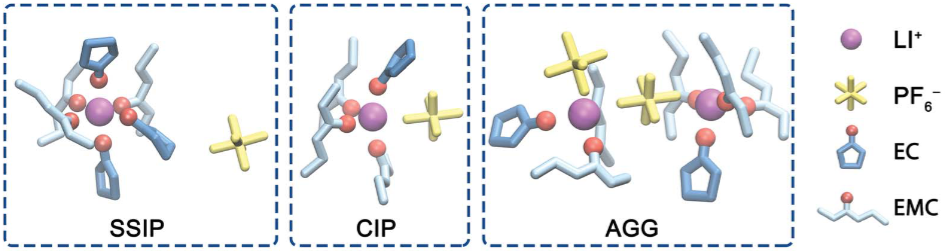

Превращение типов ионных пар друг в друга занимает сотни пикосекунд, что делает невозможным набор исчерпывающего числа их структур в ходе активного обучения с использованием обычной молекулярной динамики. Эту проблему можно решить с помощью методов enhanced sampling (например, метадинамики) или, что проще, проводить активное обучение на многих параллельных молекулярных динамиках, стартовавших с различных ионных пар.

<div style="font-size:12pt; line-height:1.4;">  
    
Из-за значительно больших вычислительных затрат по сравнению с моделированием смесей EC/EMC, в данном случае был обучен только один потенциал 20-го уровня. Далее все расчёты были выполнены только с ним, а не с ансамблем потенциалов.

В последующих ячейках вы найдёте методы обработки результатов молекулярной динамики с использованием полученного потенциала:

## RDF

Функция радиального распределения ([Radial Distribution Function](https://en.wikipedia.org/wiki/Radial_distribution_function), **RDF**) характеризует вероятность обнаружить атом типа B на расстоянии r от атома типа A. В жидкостях RDF отражает локальную структуру, например, строение сольватных оболочек вокруг ионов, где пики RDF соответствуют предпочтительным межатомным расстояниям:

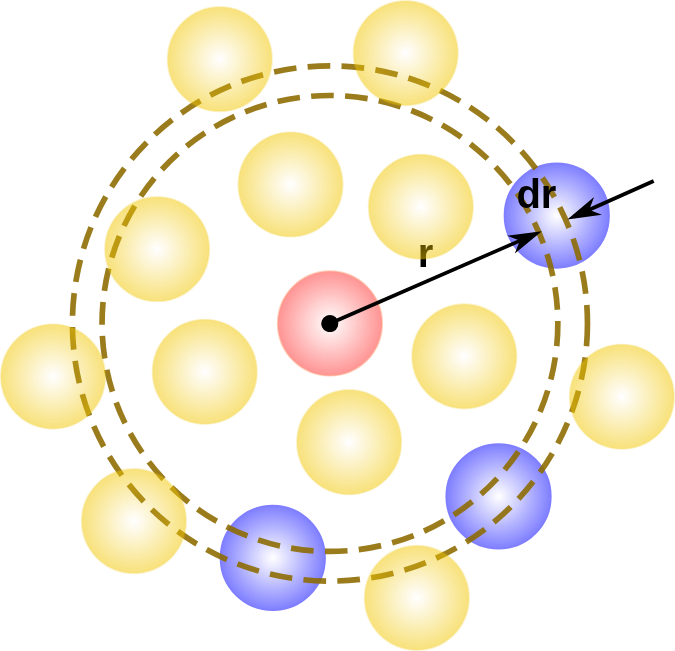

Перед расчётом RDF мы эквилибрировали плотность в течение 50 пс в NPT-ансамбле, затем перешли в NVT-ансамбль и записывали конфигурации шагов молекулярной динамики, длившейся 80 пс, в `.dump` файл каждую пикосекунду. Входной скрипт LAMMPS выглядел так:

```lammps
_-----------------------------------------------------------------------------
#----------------------------- Общие настройки -------------------------------
#-----------------------------------------------------------------------------
clear
units metal
dimension 3
boundary p p p
atom_style atomic

#-----------------------------------------------------------------------------
#---------------------- Чтение начальной структуры ---------------------------
#-----------------------------------------------------------------------------
read_data structure.data

#-----------------------------------------------------------------------------
#------------------------- Межатомный потенциал ------------------------------
#-----------------------------------------------------------------------------
pair_style mlip mlip.ini
pair_coeff * *

#-----------------------------------------------------------------------------
#----------------------------- Другие настройки ------------------------------
#-----------------------------------------------------------------------------
variable T equal 330
variable P equal 1.013
timestep 0.001
thermo 100
neighbor 0.5 bin
neigh_modify delay 1 check yes

#-----------------------------------------------------------------------------
#--------------------------- Эквилибрация ------------------------------------
#-----------------------------------------------------------------------------
velocity all create $T 123456 dist gaussian
fix 1 all npt temp $T $T 0.1 iso $P $P 1
run 50000
unfix 1

#-----------------------------------------------------------------------------
#----------------------------- Настройки вывода ------------------------------
#-----------------------------------------------------------------------------
thermo_style custom step etotal pe ke temp enthalpy vol press density
dump force all custom 100 lammps.dump id type x y z vx vy vz
dump_modify force sort id

#-----------------------------------------------------------------------------
#----------------------------- Production run --------------------------------
#-----------------------------------------------------------------------------
fix 2 all nvt temp $T $T 0.1
run 80000
unfix 2

print "All done!"

<div style="font-size:12pt; line-height:1.4;">  
    
Расчёт RDF можно выполнить и в LAMMPS — для этого не потребуется запись в `.dump` файл, но обработка `.dump` файла с помощью `MDAnalysis` даёт большую гибкость и позволяет получить дополнительную информацию (например, можно рассчитать соотношение ионных пар).

In [6]:
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF

In [13]:
# Загружаем LAMMPS .dump файл
u = mda.Universe('./LiPF6_solution/lammps.dump',  
                 format = 'LAMMPSDUMP',
                 atom_style = 'id type x y z vx vy vz')

# Заменяем типы атомов с номеров указанных в LAMMPS на физические
specorder = {'1':'15','2':'9','3':'8','4':'6','5':'3','6':'1'} # на основании structure.data
new_types = []
for t in u.atoms.types:
    new_types.append(specorder[t])
u.add_TopologyAttr('type', new_types)

# Выбираем атомы Li и O по их номерам в structure.data
li_atoms = u.select_atoms("type 3")
o_atoms = u.select_atoms("type 8")

# Может появиться UrserWarning что нет информации о массах и dt - это нормально, ее нет в и .dump файлах, и она не понадобится для расчета RDF

/home/olga/anaconda3/envs/work/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:670: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/olga/anaconda3/envs/work/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:749: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [14]:
# Расчет RDF
rdf_calc = InterRDF(li_atoms, o_atoms, nbins = 100, range = (1, 9))
rdf_calc.run()
r = rdf_calc.results.bins
rdf = rdf_calc.results.rdf

<div style="font-size:12pt; line-height:1.4;">  

Для сравнения, загружаем RDF из литературы, рассчитанные с помощью AIMD (PBE-D3) и ReaxFF [\[Ong 2015\]](https://pubs.acs.org/doi/abs/10.1021/jp508184f):

In [15]:
# загружаем RDF из литературы
rdf_ref = pd.read_table('./LiPF6_solution/Li_O_RDF.txt', sep = ',') # RDF посчитанная с помощью AIMD
rdf_ref_reaxff = pd.read_table('./LiPF6_solution/Li_O_RDF_ReaxFF.txt', sep = ',') # RDF посчитанная с помощью ReaxFF (силовое поле)

# Интерполируем литературные RDF для построения графика
from scipy.interpolate import PchipInterpolator
spl = PchipInterpolator(rdf_ref['r'], rdf_ref['g'])
rdf_ref_interpolated = pd.DataFrame()
rdf_ref_interpolated['r'] = np.linspace(np.min(rdf_ref['r']),np.max(rdf_ref['r']),200)
rdf_ref_interpolated['g']= spl(rdf_ref_interpolated['r'])

spl = PchipInterpolator(rdf_ref_reaxff['r'], rdf_ref_reaxff['g'])
rdf_ref_reaxff_interpolated = pd.DataFrame()
rdf_ref_reaxff_interpolated['r'] = np.linspace(np.min(rdf_ref_reaxff['r']),np.max(rdf_ref_reaxff['r']),200)
rdf_ref_reaxff_interpolated['g']= spl(rdf_ref_interpolated['r'])

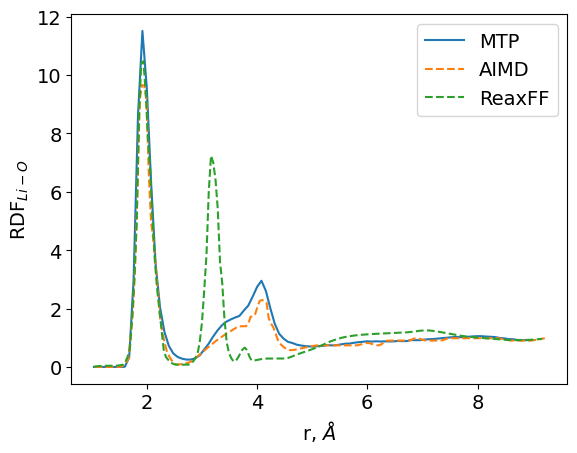

In [16]:
plt.plot(r,rdf, label = r'MTP')
plt.plot(rdf_ref_interpolated['r'], rdf_ref_interpolated['g'], '--', label = 'AIMD')
plt.plot(rdf_ref_reaxff_interpolated['r'], rdf_ref_reaxff_interpolated['g'], '--', label = 'ReaxFF')
plt.ylabel(r'RDF$_{Li-O}$')
plt.xlabel(r'r, $\AA$')
plt.legend()
plt.show()

<div style="font-size:12pt; line-height:1.4;">  

Из результатов видно, что RDF полученная из динамики в MTP значительно ближе к предсказанной из AIMD чем полученная с помощью ReaxFF.

<div style="font-size:12pt; line-height:1.4;">  
    
**Дополнительное задание:**  
Убедитесь, что второй максимум (точнее, два наложившихся максимума) на 3–4 Å относится к эфирным атомам кислорода, а первый — к карбонильным. Для этого определите номера эфирных и карбонильных атомов кислорода, добавьте эту информацию в объект `Universe` и отберите только эти атомы с помощью `select_atoms` при построении RDF. Делать это можно по аналогии с тем, как далее мы разделим всю структуру на отдельные молекулы и ионы.

## Анализ сольватных оболочек

<div style="font-size:12pt; line-height:1.4;">  
    
По структурам, записанным в `.dump` файле, можно также детально анализировать структуру раствора: определить соотношение типов ионных пар, получить координационные числа атомов Li⁺, отслеживать динамику отдельно взятого иона Li⁺ и его сольватной оболочки и многое другое.

Чтобы перейти к анализу структуры раствора, нам понадобится подготовить объект `mda.Universe` так, чтобы он содержал всю необходимую информацию для методов обработки, которые мы будем использовать.

In [7]:
# Создае объект mda.Universe на основании .dump файла (то же самое что для построения RDF)

# Загружаем LAMMPS .dump файл
u = mda.Universe('./LiPF6_solution/lammps.dump',  
                 format = 'LAMMPSDUMP',
                 atom_style = 'id type x y z vx vy vz')

# Заменяем типы атомов с номеров указанных в LAMMPS на физические
specorder = {'1':'15','2':'9','3':'8','4':'6','5':'3','6':'1'} # на основании structure.data
new_types = []
for t in u.atoms.types:
    new_types.append(specorder[t])
u.add_TopologyAttr('type', new_types)

/home/olga/anaconda3/envs/work/lib/python3.11/site-packages/MDAnalysis/topology/LAMMPSParser.py:670: UserWarning: Guessed all Masses to 1.0
  warnings.warn("Guessed all Masses to 1.0")
/home/olga/anaconda3/envs/work/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:749: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


### Разделение на отдельные молекулы и ионы

In [8]:
# Разбиваем структуры на отдельные молекулы EC, ионы Li+ и PF6-

atom_resindex = [0]*u.atoms.n_atoms
resnames = []
n_li = 0
n_pf6 = 0
n_ec = 0
n_resids = 0

# элементарная ячейка содержала 108 атомов, и была размножена как 3х3х3
n_atoms_in_unit_cell = 108
for i in range(27): # цикл по элементарным ячейкам
    # первые 7 атомов в элементарой ячейке относятся к PF6
    atom_resindex[i*n_atoms_in_unit_cell: i*n_atoms_in_unit_cell+7] = [n_resids]*7
    resnames.append(f'PF6_{n_pf6}')
    n_pf6 += 1
    n_resids += 1

    # далее следует атом Li
    atom_resindex[i*n_atoms_in_unit_cell+7] = n_resids
    resnames.append(f'Li_{n_li}')
    n_li += 1
    n_resids += 1

    # далее - 10 молекул EC 
    for j in range(10):
        atom_resindex[i*n_atoms_in_unit_cell+8+j*10: i*n_atoms_in_unit_cell+8+(j+1)*10] = [n_resids]*10
        resnames.append(f'EC_{n_ec}')
        n_ec += 1
        n_resids += 1

<div style="font-size:12pt; line-height:1.4;">  
    
Если порядок молекул в `.dump` файле неизвестен, можно разделить атомы на молекулы, используя [алгоритмы кластеризации](https://scikit-learn.org/stable/modules/clustering.html), или использовать функцию `split_molecs` из модуля `anaAtoms` пакета [aseMolec](https://github.com/imagdau/aseMolec/tree/main).

In [9]:
# Чтобы добавить информацию о принадлежности атомов к молекулам / ионам,
# создаем новый объект mda.Universe 
# (MDAnalysis не позволяет добавить информацию о пренадлежности атомов к молекулам к уже существующей Universe)
new_u = mda.Universe.empty(
                            n_atoms = u.atoms.n_atoms,
                            n_residues = n_resids,
                            atom_resindex = atom_resindex,
                            trajectory = True,
                            )
new_u.add_TopologyAttr('resnames', resnames)
new_u.add_TopologyAttr('type', u.atoms.types)
new_u.load_new('./LiPF6_solution/lammps.dump',  
                 format = 'LAMMPSDUMP',)

<Universe with 2916 atoms>

### Определение радиуса сольватной оболочки

<div style="font-size:12pt; line-height:1.4;">  

Для определения принадлежности молекул к первой сольватной оболочке Li⁺ необходимо найти, на каких расстояниях находятся атомы из EC и PF₆⁻, координированные на Li⁺. Это можно установить из анализа RDF.

In [10]:
# отделяем атомы Li и O и F (способные координироваться на Li+)
li_atoms = u.select_atoms("type 3")
o_atoms = u.select_atoms("type 8")
f_atoms = u.select_atoms("type 9")

In [11]:
rdf_calc = InterRDF(li_atoms, o_atoms, nbins = 100, range = (1, 9))
rdf_calc.run()
r_LiO = rdf_calc.results.bins
rdf_LiO = rdf_calc.results.rdf

rdf_calc = InterRDF(li_atoms, f_atoms, nbins = 100, range = (1, 9))
rdf_calc.run()
r_LiF = rdf_calc.results.bins
rdf_LiF = rdf_calc.results.rdf

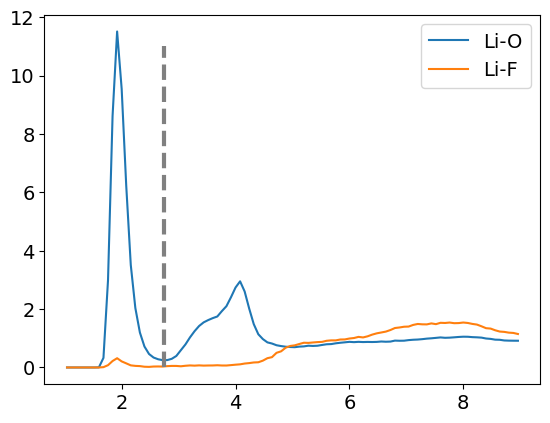

In [12]:
plt.plot(r_LiO, rdf_LiO, label = 'Li-O')
plt.plot(r_LiF, rdf_LiF, label = 'Li-F')
plt.vlines(2.75, 0, 11, linestyle='--', linewidth = 3, color = 'gray')
plt.legend()
plt.show()

<div style="font-size:12pt; line-height:1.4;">  

Из результатов видно, что преимущественно рядом с Li⁺ находятся атомы O (молекулы EC), а не F (анионы PF₆⁻). Определяем радиус, внутри которого размещаются ближайшие O из EC, входящие в первую сольватную оболочку.

Однако при увеличении масштаба распределения Li–F на ~2 Å, также видно небольшой сигнал на этой RDF:

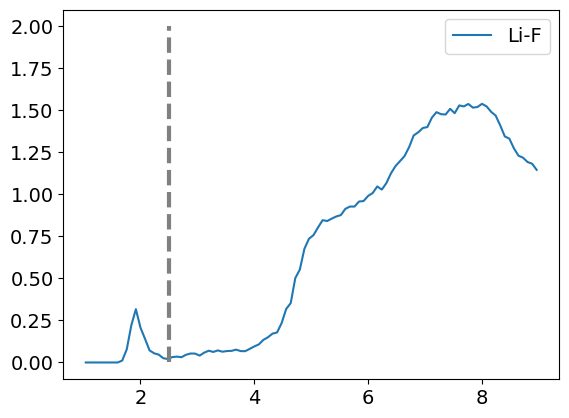

In [13]:
plt.plot(r_LiF, rdf_LiF, label = 'Li-F')
plt.vlines(2.5, 0, 2, linestyle='--', linewidth = 3, color = 'gray')
plt.legend()
plt.show()

<div style="font-size:12pt; line-height:1.4;"> 

Значит, существует небольшое число сольватных оболочек, в которые входит PF₆⁻. Определяем радиус, внутри которого размещаются ближайшие F из PF₆⁻, входящие в первую сольватную оболочку.

<div style="font-size:12pt; line-height:1.4;">  
    
После того как были определены характерные расстояния, на которых координируются O и F, можно приступать к анализу сольватных оболочек. Для этого нужно создать объект `Solute` из модуля `solvation_analysis`, для которого уже реализованы множество методов анализа.

### Разделение на растворитель и растворенное вещество

In [14]:
import solvation_analysis
from solvation_analysis import Solute

In [15]:
# Разделяем всю систему на ионы Li+ и PF6- и молекулы EC 
Li = new_u.atoms.select_atoms("resname Li_0 "+''.join([f' or resname Li_{i}' for i in range(1,n_li)]))
PF6 = new_u.atoms.select_atoms("resname PF6_0 "+''.join([f' or resname PF6_{i}' for i in range(1,n_pf6)]))
EC = new_u.atoms.select_atoms("resname EC_0 "+''.join([f' or resname EC_{i}' for i in range(1,n_ec)]))

In [16]:
# Создаем объект solute для анализа сольватных оболочек Li+
solute = Solute.from_atoms(solute_atoms = Li, 
                           solvents = {'PF6': PF6, 'EC': EC}, 
                           solute_name="Li",
                           radii={'PF6': 2.5, 'EC': 2.75},
                          )

solute.run()

/home/olga/anaconda3/envs/work/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:749: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [17]:
solvation_data = solute.solvation_data.sort_values(["frame", "solute_ix", "distance"])

<div style="font-size:12pt; line-height:1.4;">  

Так, мы получили информацию о том какие молекулы координированы на каком ионе Li$^+$ в зависимости от времени (точнее от порядкового номера структуры в `.dump` файле)

In [18]:
solvation_data

distance solute solvent  \
frame solute_ix solute_atom_ix solvent_atom_ix                            
0     1         7              413              1.854582     Li      EC   
                               2348             1.916471     Li      EC   
                               738              1.997123     Li      EC   
                               2602             2.011461     Li      EC   
      13        115            2838             1.839937     Li      EC   
...                                                  ...    ...     ...   
800   301       2707           1268             2.259211     Li      EC   
      313       2815           569              1.955902     Li      EC   
                               1846             1.976644     Li      EC   
                               2846             1.987844     Li      EC   
                               236              2.033408     Li      EC   

                                                solvent_ix  
frame solute_ix solute_atom_ix solvent_atom_ix              
0     1         7              413                      46  
                               2348                    261  
                               738                      82  
                               2602                    290  
      13        115            2838                    316  
...                                                    ...  
800   301       2707           1268                    141  
      313       2815           569                      64  
                               1846                    206  
                               2846                    317  
                               236                      27  

[92821 rows x 4 columns]

<div style="font-size:12pt; line-height:1.4;">  

Известно что в растворе LiPF$_6$ в чистом EC доминируют сольватно-разделенные ионные пары, то есть в основном сольватные оболочки должны содержать только молекулы EC.
Проверяем что есть сольватные оболочки куда входит PF$_6^-$:

In [29]:
solvation_data.loc[solvation_data['solvent']=='PF6']

distance solute solvent  \
frame solute_ix solute_atom_ix solvent_atom_ix                            
0     265       2383           2381             2.056823     Li     PF6   
      277       2491           2486             1.741486     Li     PF6   
1     265       2383           2381             2.057277     Li     PF6   
      277       2491           2486             2.053572     Li     PF6   
2     265       2383           2381             1.786316     Li     PF6   
...                                                  ...    ...     ...   
348   277       2491           2490             1.845274     Li     PF6   
349   277       2491           2486             2.131109     Li     PF6   
350   277       2491           2486             1.940808     Li     PF6   
351   277       2491           2486             2.205649     Li     PF6   
352   277       2491           2486             2.040230     Li     PF6   

                                                solvent_ix  
frame solute_ix solute_atom_ix solvent_atom_ix              
0     265       2383           2381                    264  
      277       2491           2486                    276  
1     265       2383           2381                    264  
      277       2491           2486                    276  
2     265       2383           2381                    264  
...                                                    ...  
348   277       2491           2490                    276  
349   277       2491           2486                    276  
350   277       2491           2486                    276  
351   277       2491           2486                    276  
352   277       2491           2486                    276  

[372 rows x 4 columns]

<div style="font-size:12pt; line-height:1.4;">  

Такие сольватные оболочки присутствуют в записанных структурах, однако их число невелико по сравнению с общим количеством, и они встречаются лишь в начале молекулярной динамики.

<div style="font-size:12pt; line-height:1.4;">  
    
`solvation_analysis` предоставляет множество готовых методов для анализа структуры раствора. С их помощью можно, например, рассчитать долю различных сольватных оболочек:

In [30]:
print('Доля сольватных оболочек (по всем шагам МД) с 1 ионом PF6-: ', solute.speciation.calculate_shell_fraction({'PF6': 1}))

Доля сольватных оболочек (по всем шагам МД) с 1 ионом PF6-:  0.01720072132057151


In [31]:
print('Доля сольватных оболочек (по всем шагам МД) с 2 ионами PF6-: ', solute.speciation.calculate_shell_fraction({'PF6': 2}))

Доля сольватных оболочек (по всем шагам МД) с 2 ионами PF6-:  0.0


In [32]:
print('Доля сольватных оболочек (по всем шагам МД) с 2 молекулами EC и 1 ионом PF6: ', solute.speciation.calculate_shell_fraction({'PF6': 1,'EC': 2}))

Доля сольватных оболочек (по всем шагам МД) с 2 молекулами EC и 1 ионом PF6:  0.0011097239561659038


<div style="font-size:12pt; line-height:1.4;">  
Можно посмотреть какие именно ионы Li+ входят в сольватные оболочки с заданным составом:

In [33]:
solute.speciation.get_shells({'PF6': 1, 'EC': 2}).head(12)

,solvent,EC,PF6
frame,solute_ix,,
75,277,2,1
76,277,2,1
77,277,2,1
78,277,2,1
153,277,2,1
154,277,2,1
155,277,2,1
156,277,2,1
178,277,2,1


<div style="font-size:12pt; line-height:1.4;">  

Множество других функций — от извлечения структуры отдельной сольватной оболочки до визуализации сетей, связывающих ионы и растворителя — описаны в [официальной документации](https://solvation-analysis.readthedocs.io/en/latest/index.html).

### Визуализация динамики сольватной оболочки

<div style="font-size:12pt; line-height:1.4;">  

Иногда информативно визуализировать динамику отдельных сольватных оболочек — например, чтобы оценить, насколько физично ведёт себя потенциал. В следующих ячейках вы найдёте функции, которые позволяют извлечь структуру сольватной оболочки выбранного иона Li$^+$ и визуализировать ее динамику.

In [19]:
def atomgroup2aseatoms (atom_group, frame):
    """ 
    Функия для создания объекта ase.Atoms (для которого доступно много методов визуализации) из обекта mda.atom_group, использующегося в MDAnalysis
    """
    atom_group.universe.trajectory[frame]
    if (atom_group.dimensions != None).any():
        pbc = [True,True,True]
        cell = atom_group.dimensions
    else:
        pbc = [False,False,False]
                
    atoms = Atoms(positions = atom_group.atoms.positions, 
                  numbers = atom_group.atoms.types, 
                  pbc = pbc,
                  cell = cell)
    return atoms

<div style="font-size:12pt; line-height:1.4;">  
    
Выберем набор шагов МД, которые будем анализировать

In [25]:
selected_frames = np.arange(0, new_u.trajectory.n_frames, 10)

<div style="font-size:12pt; line-height:1.4;">  

Для удобства, «достроим» все молекулы, чтобы они не выглядели разорванными из-за периодических граничных условий:

In [34]:
from MDAnalysis.lib.distances import apply_PBC, minimize_vectors
def unwrap_atom_group_pbc(ag):
    """
    Достраивание молекул до "целых" на основании пренадлежности атомов к молекулам
    """
    def transform(ts):
        for residue in ag.residues: # цикл по ионам / молекулам
            atoms = residue.atoms

            # если ион / молекула состоит только из одного атома, то пропускаем
            if len(atoms) == 1:
                continue 
                
            # изначальные координаты атомов
            pos = atoms.positions

            # геометрический центр молекулы
            cog = atoms.center_of_geometry()
            
            # набор векторов соединяющих все атомы с геометрическим центром 
            vecs = pos - cog

            # смещаем все атомы так чтобы они были близко к геометрическому центру
            vecs = minimize_vectors(vecs, ts.dimensions)
            new_pos = cog + vecs
            atoms.positions = new_pos
        
        return ts
    
    return transform

In [21]:
new_u.trajectory.add_transformations(unwrap_atom_group_pbc(new_u.atoms))

<div style="font-size:12pt; line-height:1.4;">   
    
Для удобства нам также понадобится словарь, соотносящий номер молекулы/иона в объекте universe (созданный нами список resids) с именем присвоенному этому объекту (созданный нами список resnames)

In [22]:
Li_solute_indexes_to_resnames = dict(zip(Li.residues.resindices,Li.residues.resnames)) 

In [23]:
Li_solute_indexes_to_resnames[277]

'Li_23'

<div style="font-size:12pt; line-height:1.4;">   
Теперь мы выбираем в отдельную группу атомов только Li_10 и его сольватную оболочку:

In [26]:
atoms_ase = []
for frame in selected_frames:
    solvation_shell=solute.get_shell(solute_index=277, frame = frame)
    atoms_ase.append(atomgroup2aseatoms(solvation_shell, frame))

/home/olga/anaconda3/envs/work/lib/python3.11/site-packages/MDAnalysis/coordinates/LAMMPS.py:749: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


In [30]:
visualize_chemiscope(atoms_ase, 'frame', selected_frames, 'frame1', selected_frames)

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'unitCell': True, 'keepOrientation': True}]}, s…

<div style="font-size:12pt; line-height:1.4;">  
    
Можно выбрать несколько ионов Li+ и их сольватные оболочки:

In [28]:
atoms_ase_several_li = []
for frame in selected_frames:
    solvation_shells = []
    for idx in [13, 121, 277]:
        solvation_shells.append(solute.get_shell(solute_index=idx, frame = frame))
    atoms_ase_several_li.append(atomgroup2aseatoms(sum(solvation_shells, new_u.atoms[[]]), frame))

In [29]:
visualize_chemiscope(atoms_ase_several_li, 'frame', selected_frames, 'frame1', selected_frames)

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'unitCell': True, 'keepOrientation': True}]}, s…

<div style="font-size:12pt; line-height:1.4;">  
    
И можно смотреть изменения структуры в зависимость от среднеквадратичного смещения

In [31]:
from MDAnalysis.analysis import msd

In [32]:
msd_calc = msd.EinsteinMSD(
    new_u,
    select=f'resname {Li_solute_indexes_to_resnames[277]}',
    msd_type='xyz',      # 'xyz' - для расчета смещений по всем направлениям, можно исчтать и по отдельным ( 'x' или 'xy')
    fft=False,
)
msd_calc.run()
msd_values = list(msd_calc.results.timeseries)  # in Å²

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:00<00:00, 73211.80it/s]


In [33]:
visualize_chemiscope(atoms_ase, 'frame', selected_frames, 'MSD', [msd_values[i] for i in selected_frames])

<ChemiscopeWidget(meta={'name': ' '}, settings={'structure': [{'unitCell': True, 'keepOrientation': True}]}, s…